In [ ]:
import pandas as pd
import matplotlib as plt




In [ ]:

def GH_table(pred,y,gh,podar_limites=False):
    # gh = quantidade de grupos desejado 
    # podar_limite = trazer corte minimo da predição para 0 e maximo para 1
    df = pd.DataFrame({'real':y,'pred':pred})
    #Criar GH
    q = 1
    passo = 1/gh
    df['GH']=0
    for i in range(gh):
        maxi = df['pred'].quantile(q)+0.00000001
        mini = df['pred'].quantile(q-passo)
        df['GH'][((df['pred'] < maxi) & (df['pred']>=mini))] = (gh-i)
        q = round((1 -(1+i)*passo),7)
    df['GH'][df['GH']==0]=1
    
    #agrupar dados por GH
    df = df.groupby('GH').agg({'real':['count','sum'],'pred':['max','min','mean']})
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()
    
    #Criar colunas
    df['%_freq'] = round(df['real_count']/df['real_count'].sum(),4)
    df['%_taxa_target_1'] = df['real_sum']/df['real_count']
    df['#_target_0'] = df['real_count']-df['real_sum']
    df['ODDS'] = df['real_sum']/(df['#_target_0'])
    df['pred_min'] =df['pred_max'].shift(1)
    #renomear
    df.rename(columns={'real_count':'#_freq','real_sum':'#_target_1',
                       'pred_max':'limite_pred_superior','pred_min':'limite_pred_inferior',
                       'pred_mean':'pred_media_modelo'},inplace=True)
    
    #ordenar
    df = df[['GH', '#_freq', '%_freq', '#_target_1', '#_target_0', 'limite_pred_superior',
       'limite_pred_inferior', 'pred_media_modelo',
       '%_taxa_target_1', 'ODDS']]
    
    #podar limites (opcional)
    if podar_limites==True:
        df['limite_pred_inferior'][df.limite_pred_inferior.isna()]=-0.2
        df['limite_pred_superior'][df.limite_pred_superior==df.limite_pred_superior.max()]=1.2
        
    df['%_cum_0'] = df['#_target_0'].cumsum() / df['#_target_0'].sum()
    df['%_cum_1'] = df['#_target_1'].cumsum() / df['#_target_1'].sum()
    df['ks'] = df['%_cum_0']-df['%_cum_1']
    
    df = df.drop('pred_media_modelo',1)
    
    return df

def GH_table_tratado(pred,y,gh,podar_limites=False):
    # gh = quantidade de grupos desejado 
    # podar_limite = trazer corte minimo da predição para 0 e maximo para 1
    df = pd.DataFrame({'real':y,'pred':pred})
    #Criar GH
    df['GH']=0
    for i in range(len(gh)):
        df['GH'][((df['pred'] < gh.loc[i,'limite_pred_superior']) & (df['pred']>=gh.loc[i,'limite_pred_inferior']))] = (gh.loc[i,'GH'])

    
    #agrupar dados por GH
    df = df.groupby('GH').agg({'real':['count','sum'],'pred':['max','min','mean']})
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()
    
    #Criar colunas
    df['%_freq'] = round(df['real_count']/df['real_count'].sum(),4)
    df['%_taxa_target_1'] = df['real_sum']/df['real_count']
    df['#_target_0'] = df['real_count']-df['real_sum']
    df['ODDS'] = df['real_sum']/(df['#_target_0'])
    df['pred_min'] =df['pred_max'].shift(1)
    #renomear
    df.rename(columns={'real_count':'#_freq','real_sum':'#_target_1',
                       'pred_max':'limite_pred_superior','pred_min':'limite_pred_inferior',
                       'pred_mean':'pred_media_modelo'},inplace=True)
    
    #ordenar
    df = df[['GH', '#_freq', '%_freq', '#_target_1', '#_target_0', 'limite_pred_superior',
       'limite_pred_inferior', 'pred_media_modelo',
       '%_taxa_target_1', 'ODDS']]
    
    #podar limites (opcional)
    if podar_limites==True:
        df['limite_pred_inferior'][df.limite_pred_inferior.isna()]=-0.2
        df['limite_pred_superior'][df.limite_pred_superior==df.limite_pred_superior.max()]=1.2
        
    df['%_cum_0'] = df['#_target_0'].cumsum() / df['#_target_0'].sum()
    df['%_cum_1'] = df['#_target_1'].cumsum() / df['#_target_1'].sum()
    df['ks'] = df['%_cum_0']-df['%_cum_1']
    
    df = df.drop('pred_media_modelo',1)
    
    return df

def plot_GH(pred,y,date,GH_params):
    df = pd.DataFrame({'pred':pred,'real':y,'date':date})
    df['GH']=0
    for i in range(len(GH_params)):
        df.loc[(df.pred>GH_params.limite_pred_inferior[i])&(df.pred<=GH_params.limite_pred_superior[i]),'GH']=GH_params.GH[i]
    df = df.groupby(['GH','date'])['real'].mean().reset_index()
    df = df[df['date']>4]
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.lineplot(x="date", y="real", hue="GH",data=df)    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return #df.head()

def plot_GH_vol(pred,y,date,GH_params):
    df = pd.DataFrame({'pred':pred,'real':y,'date':date})
    df['GH']=0
    for i in range(len(GH_params)):
        df.loc[(df.pred>GH_params.limite_pred_inferior[i])&(df.pred<=GH_params.limite_pred_superior[i]),'GH']=GH_params.GH[i]
        df = df[df['date']>4]
    df = df.groupby(['GH','date'])['real'].count()
    
    df = df.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

    return df




## Load Train Result

In [2]:
# df_test_out = pd.read_csv("../data/processed/result_test.csv")
df_test_out = pd.read_csv("df_result_total.csv")

In [3]:
df_test_out

ClientId  real  pred     proba  GH
0        1290926     1     0  0.466997   6
1          63571     0     0  0.102449   9
2        1452022     0     0  0.481696   6
3         523090     0     1  0.809710   2
4         105799     0     0  0.481696   6
...          ...   ...   ...       ...  ..
355096    735640     0     0  0.406145   6
355097   1974977     0     0  0.245252   8
355098    201949     0     0  0.481696   6
355099   2123913     0     0  0.348108   7
355100    691927     0     0  0.481696   6

[355101 rows x 5 columns]

## Get target and month

In [4]:
df_ref = pd.read_csv("../data/interim/referencia.csv")

In [5]:
df_ref['target']= df_ref['EVER60']

In [6]:
df_target_month = df_ref[['ClientId', 'target', 'M0']]

In [7]:
df_target_month['M0'] = pd.to_datetime(df_target_month['M0'])

/Users/dafne.coelho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
# df_target_month

## Over GHs Safras

In [9]:
df_test_out = df_test_out.merge(df_target_month, on='ClientId')

In [10]:
df_test_out.columns

Index(['ClientId', 'real', 'pred', 'proba', 'GH', 'target', 'M0'], dtype='object')

In [11]:
# df_test_out['M0'] = pd.to_datetime(df_test_out['M0'])

### Count per safra

In [12]:
df_test_out.groupby('M0')['ClientId'].count().reset_index()

M0  ClientId
0  2019-05-03     47595
1  2019-05-10     47602
2  2019-05-17     47553
3  2019-05-24     47330
4  2019-05-31     47301
5  2019-06-07     71170
6  2019-06-14     70122
7  2019-06-21     70666
8  2019-06-28     70292
9  2019-07-05     77309
10 2019-07-12     76955
11 2019-07-19     76777
12 2019-07-26     76138
13 2019-08-02     64944
14 2019-08-09     64907
15 2019-08-16     64502
16 2019-08-23     64155
17 2019-08-30     63576
18 2019-09-06     85608
19 2019-09-13     84336
20 2019-09-20     84077
21 2019-09-27     83976

In [13]:
# df_test_out = df_test_out[(df_test_out.M0!='2019-06-30')&(df_test_out.M0!='2019-07-31')]

In [14]:
df_test_out.columns

Index(['ClientId', 'real', 'pred', 'proba', 'GH', 'target', 'M0'], dtype='object')

In [15]:
ghs = list(set(df_test_out.GH.unique()))

In [16]:
ghs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [17]:
safras = list(set(df_test_out.M0.unique()))

In [18]:
# safras

In [19]:
# df_train_score.groupby(['month', 'GH'])['ClientId'].count()

df_test_out.columns

Index(['ClientId', 'real', 'pred', 'proba', 'GH', 'target', 'M0'], dtype='object')

In [20]:
df_test_out['M0'] = pd.to_datetime(df_test_out['M0'])

In [21]:
dict_ghs={}
for gh in ghs:
    dict_safras = {}
    for safra in safras:
        df_temp = df_test_out[(df_test_out['GH']==gh)&(df_test_out['M0']==safra)].copy()
        percent_bad_real = df_temp[df_temp['target']==1]['ClientId'].count()/df_temp['ClientId'].count()
        percent_bad_real = percent_bad_real*100
        dict_safras[safra] = percent_bad_real
    dict_ghs[gh]=dict_safras                                                                                                                                                                                                                                                                

# dict_ghs

In [22]:
df_ghs_safras = pd.DataFrame(dict_ghs)

In [23]:
df_ghs_safras

1          2          3          4          5         6   \
2019-05-24  73.029625  49.441505  31.953353  19.727891  10.718294  3.122432   
2019-06-07  75.217770  51.968174  35.581854  22.678397  11.947146  4.167553   
2019-08-09  71.423635  54.835282  43.108504  30.290456  17.895626  7.265492   
2019-07-26  69.939327  56.505878  42.490047  28.111401  16.723000  6.597850   
2019-05-31  71.038544  48.158803  33.294187  18.834547   8.922899  3.235848   
2019-07-12  71.833840  55.210549  41.630733  27.012195  16.160916  5.405665   
2019-08-23  66.462949  52.934899  43.758330  31.907045  18.026870  7.343786   
2019-09-20  56.347746  46.411225  40.776699  31.240382  20.932878  9.241746   
2019-05-17  71.700757  48.732719  29.752066  17.477563   9.587482  2.685390   
2019-06-28  71.153846  52.204448  37.164751  23.503989  11.775563  4.525540   
2019-07-19  72.985302  55.164226  42.662242  28.907413  14.864401  5.897522   
2019-08-02  68.323191  53.449243  41.932221  30.094044  17.634724  6.984323   
2019-08-30  63.514680  52.127660  42.410304  30.790665  19.380316  7.466500   
2019-08-16  66.383151  53.287593  42.608696  30.029369  17.795591  7.581627   
2019-09-27  56.349206  45.595596  38.267148  33.121937  22.569815  9.312460   
2019-09-13  54.942810  47.200419  40.440565  30.781153  19.407478  8.409317   
2019-05-10  73.746496  47.624703  34.761018  18.549581   8.994557  2.947977   
2019-07-05  71.463523  50.555115  39.270633  26.261960  14.412779  5.487326   
2019-05-03  70.699881  42.823940  28.352038  15.938431   6.664709  2.528884   
2019-09-06  63.524738  52.092149  42.253521  32.525742  18.871692  8.565028   
2019-06-14  73.953383  52.549342  40.073529  23.529412  13.237790  4.623507   
2019-06-21  71.586110  52.840213  38.467615  22.064516  12.890769  4.165142   

                  7         8         9         10  
2019-05-24  2.728236  2.449514  1.661538  1.068702  
2019-06-07  3.938412  2.870570  1.818590  1.146789  
2019-08-09  7.002905  6.050695  4.231975  3.588040  
2019-07-26  5.696359  4.433193  3.718919  2.365237  
2019-05-31  2.182205  1.444924  1.266605  1.373932  
2019-07-12  5.742473  4.135119  3.131032  2.664399  
2019-08-23  7.471546  6.134372  4.299948  3.633333  
2019-09-20  9.295330  8.373456  5.379225  4.707792  
2019-05-17  2.202990  1.854232  1.234949  1.145038  
2019-06-28  4.027261  3.083644  2.651602  1.569815  
2019-07-19  5.834825  5.520895  3.055735  2.571819  
2019-08-02  6.776288  5.242588  4.144943  3.301887  
2019-08-30  7.362098  6.387633  5.169247  2.851182  
2019-08-16  7.147947  5.953693  4.405738  2.642881  
2019-09-27  8.596566  7.071148  5.682992  3.774105  
2019-09-13  8.047346  7.095414  5.773531  4.583103  
2019-05-10  2.729424  1.672598  1.212856  0.994109  
2019-07-05  5.335859  3.952258  2.903850  2.296624  
2019-05-03  2.725078  1.416532  0.906533  0.416667  
2019-09-06  8.916007  7.459066  6.552538  3.758044  
2019-06-14  3.855583  3.028767  1.983769  2.097291  
2019-06-21  4.038483  3.178640  1.939367  2.128867

In [24]:
df_ghs_safras.columns = ['gh_' + str(col) for col in df_ghs_safras.columns]

In [25]:
df_ghs_safras.sort_index()

gh_1       gh_2       gh_3       gh_4       gh_5      gh_6  \
2019-05-03  70.699881  42.823940  28.352038  15.938431   6.664709  2.528884   
2019-05-10  73.746496  47.624703  34.761018  18.549581   8.994557  2.947977   
2019-05-17  71.700757  48.732719  29.752066  17.477563   9.587482  2.685390   
2019-05-24  73.029625  49.441505  31.953353  19.727891  10.718294  3.122432   
2019-05-31  71.038544  48.158803  33.294187  18.834547   8.922899  3.235848   
2019-06-07  75.217770  51.968174  35.581854  22.678397  11.947146  4.167553   
2019-06-14  73.953383  52.549342  40.073529  23.529412  13.237790  4.623507   
2019-06-21  71.586110  52.840213  38.467615  22.064516  12.890769  4.165142   
2019-06-28  71.153846  52.204448  37.164751  23.503989  11.775563  4.525540   
2019-07-05  71.463523  50.555115  39.270633  26.261960  14.412779  5.487326   
2019-07-12  71.833840  55.210549  41.630733  27.012195  16.160916  5.405665   
2019-07-19  72.985302  55.164226  42.662242  28.907413  14.864401  5.897522   
2019-07-26  69.939327  56.505878  42.490047  28.111401  16.723000  6.597850   
2019-08-02  68.323191  53.449243  41.932221  30.094044  17.634724  6.984323   
2019-08-09  71.423635  54.835282  43.108504  30.290456  17.895626  7.265492   
2019-08-16  66.383151  53.287593  42.608696  30.029369  17.795591  7.581627   
2019-08-23  66.462949  52.934899  43.758330  31.907045  18.026870  7.343786   
2019-08-30  63.514680  52.127660  42.410304  30.790665  19.380316  7.466500   
2019-09-06  63.524738  52.092149  42.253521  32.525742  18.871692  8.565028   
2019-09-13  54.942810  47.200419  40.440565  30.781153  19.407478  8.409317   
2019-09-20  56.347746  46.411225  40.776699  31.240382  20.932878  9.241746   
2019-09-27  56.349206  45.595596  38.267148  33.121937  22.569815  9.312460   

                gh_7      gh_8      gh_9     gh_10  
2019-05-03  2.725078  1.416532  0.906533  0.416667  
2019-05-10  2.729424  1.672598  1.212856  0.994109  
2019-05-17  2.202990  1.854232  1.234949  1.145038  
2019-05-24  2.728236  2.449514  1.661538  1.068702  
2019-05-31  2.182205  1.444924  1.266605  1.373932  
2019-06-07  3.938412  2.870570  1.818590  1.146789  
2019-06-14  3.855583  3.028767  1.983769  2.097291  
2019-06-21  4.038483  3.178640  1.939367  2.128867  
2019-06-28  4.027261  3.083644  2.651602  1.569815  
2019-07-05  5.335859  3.952258  2.903850  2.296624  
2019-07-12  5.742473  4.135119  3.131032  2.664399  
2019-07-19  5.834825  5.520895  3.055735  2.571819  
2019-07-26  5.696359  4.433193  3.718919  2.365237  
2019-08-02  6.776288  5.242588  4.144943  3.301887  
2019-08-09  7.002905  6.050695  4.231975  3.588040  
2019-08-16  7.147947  5.953693  4.405738  2.642881  
2019-08-23  7.471546  6.134372  4.299948  3.633333  
2019-08-30  7.362098  6.387633  5.169247  2.851182  
2019-09-06  8.916007  7.459066  6.552538  3.758044  
2019-09-13  8.047346  7.095414  5.773531  4.583103  
2019-09-20  9.295330  8.373456  5.379225  4.707792  
2019-09-27  8.596566  7.071148  5.682992  3.774105

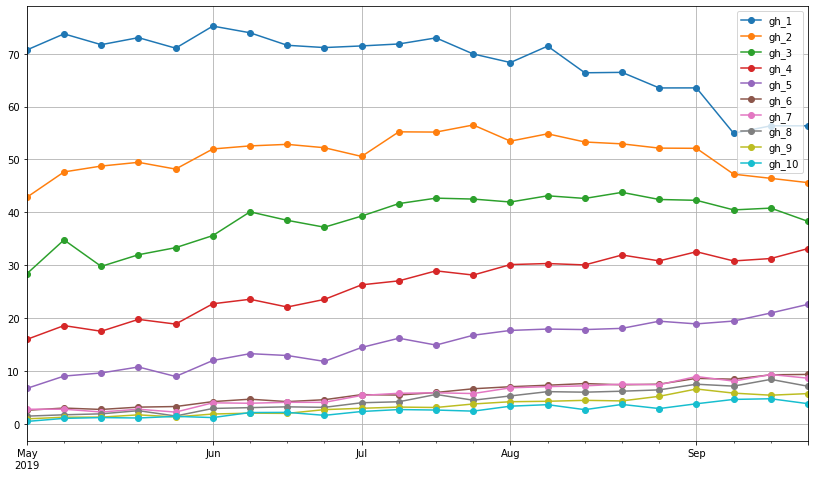

In [27]:
df_ghs_safras.sort_index().plot(figsize=(14, 8), marker='o', grid =True)